Goal: assess performance of tensor decompsition, and in particular the "how" paramater, in the presence of changing/missing cell types across contexts

In [2]:
suppressPackageStartupMessages({
    library(splatter)
    
    library(scater)
    library(scran)
    library(bluster)
    
    library(stringr)
    library(ggpubr, quietly = T)
    
    library(plyr, quietly = T)
    library(reshape2, quietly = T)
    
    library(StabEco, quietly = T)
    library(igraph, quietly = T)
    
    library(liana, quietly = T)
    library(tibble, quietly = T)
    c2c <- reticulate::import(module = "cell2cell", as="c2c")
    
    library(ggplot2, quietly = T)

})

seed <- 888
set.seed(seed)
n.cores <- 15

env.name<-'ccc_protocols'
data.path<-'/data3/hratch/ccc_protocols/'
source('./simulation_functions.r')

# Functions

In [2]:
random.omit<-function(sim, md.group.label, frac, seed = 888){
    md.group<-unique(sim[[md.group.label]])
    n.md.group<-length(md.group)
    set.seed(seed)
    omit.md.group = sort(as.character(sample(md.group, size = frac*n.md.group, replace = FALSE)))
    
    return(omit.md.group)
}
                     
# get all unique elements in each tensor dimension
get.tensor.elements<-function(scores.list, score.type){
    senders<-unique(sort(unique(unname(unlist(sapply(scores.list[[score.type]], function (context.score) unique(context.score$source)))))))
    receivers<-unique(sort(unique(unname(unlist(sapply(scores.list[[score.type]], function (context.score) unique(context.score$target)))))))
    LRs<-unique(sort(unique(unname(unlist(sapply(scores.list[[score.type]], function (context.score) unique(paste0(context.score$ligand, '&', context.score$receptor))))))))
    contexts<-unique(sort(unique(names(scores.list[[score.type]]))))
    return(list(senders = senders, receivers = receivers, LRs = LRs, contexts = contexts))
}
                                                 
# adapted from liana_tensor_c2c
# for when build_only is set to True, this will allow you to then decompose the built tensor
decompose_tensor <- function(tensor,
                             score_col = 'LRscore',
                             lr_sep="^",
                             context_order=NULL,
                             sort_elements=TRUE,
                             device=NULL,
                             rank=NULL,
                             seed = 1337,
                             upper_rank = 25,
                             runs = 1,
                             init = 'svd',
                             factors_only = TRUE,
                             conda_env=NULL,
                             verbose = TRUE,
                             inplace=TRUE,
                             sender_col = "source",
                             receiver_col = "target",
                             ligand_col = "ligand.complex",
                             receptor_col = "receptor.complex",
                             ...){

    # Deal with rank
    rank <- if(is.null(rank)){ NULL } else {as.integer(rank)}

    # Load correct conda env
    if(!is.null(conda_env)){
        print(str_glue("Loading `{conda_env}` Conda Environment"),
                      verbose = verbose,
                      output = "message")
        reticulate::use_condaenv(condaenv = conda_env,
                                 conda = "auto",
                                 required = TRUE)
    } else{
        # load basilisk env
        print(str_glue("Setting up Conda Environment with Basilisk"),
                      verbose = verbose,
                      output = "message")

        # Set up basilisk
        liana_env <- basilisk::BasiliskEnvironment(envname="liana_cell2cell",
                                                   pkgname="liana",
                                                   packages=.lianapy_packages,
                                                   pip=.liana_pips)
        basilisk::basiliskStart(liana_env, testload="scipy.optimize")
    }
    reticulate::py_set_seed(seed)

    # Import c2c
    c2c <- reticulate::import(module = "cell2cell", as="c2c")

    # Format scores to tensor
    print(str_glue("Building the tensor..."),
                  verbose = verbose,
                  output = "message")

    # estimate factor rank
    if(is.null(rank)){
        print(str_glue("Estimating ranks..."),
                      verbose = verbose,
                      output = "message")
        tensor$elbow_rank_selection(upper_rank=as.integer(upper_rank),
                                               runs=as.integer(runs),
                                               init=init,
                                               automatic_elbow=TRUE,
                                               random_state=as.integer(seed))
        rank <- as.integer(tensor$rank)
    }


    # Compute tensor factorization
    print(str_glue("Decomposing the tensor..."),
                  verbose = verbose,
                  output = "message")
    tensor$compute_tensor_factorization(rank = as.integer(rank),
                                        random_state=as.integer(seed),
                                        ...)

    if(factors_only){
        res <- format_c2c_factors(tensor$factors)
    } else{
         res <- tensor
        }

    if(!inplace){
        return(res)
    } else{
        sce@metadata$tensor_res <- res
        return(sce)
    }
}

# Simulation

Simulation parameters:

In [3]:
base_params <- newSplatParams()
n.cells<-5e3#60e3
n.cell.types<-6
n.genes<-2e3
n.lrs<-2e2

n.batches<-5 # of contexts

sim_params <- setParams(
    base_params,
    seed = seed,
    nGenes = n.genes,
    
    # batches - introduce mild ones to have context-driven changes since will treat batch as context
    batchCells = rep(n.cells/n.batches, n.batches),
    batch.rmEffect = FALSE, 
    batch.facLoc = 0.125, # higher values increase batch severity
    batch.facScale = 0.125, # higher values increase batch severity
    # cell types
    group.prob = rep(1/n.cell.types, n.cell.types), 
    de.facLoc = 0.3, # increase separation between cell types
    de.facScale = 0.6 # increase separation between cell types
)

In [4]:
# create the gold standard dataset
sim.gold<-splatSimulateGroups(sim_params, verbose = F)

# run basic qc 
sim.gold<-qc.data(sim.gold)

The cell counts are as follows:

In [5]:
df<-data.frame(colData(sim.gold))
cell.counts<-ddply(df, .(df$Batch, df$Group), nrow)
reshape2::dcast(df, Batch ~ Group)

Using Discard as value column: use value.var to override.

Aggregation function missing: defaulting to length



Batch,Group1,Group2,Group3,Group4,Group5,Group6
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
Batch1,159,147,165,176,147,176
Batch2,150,140,179,172,151,167
Batch3,173,160,162,165,149,161
Batch4,153,151,161,175,147,161
Batch5,145,161,163,170,159,171


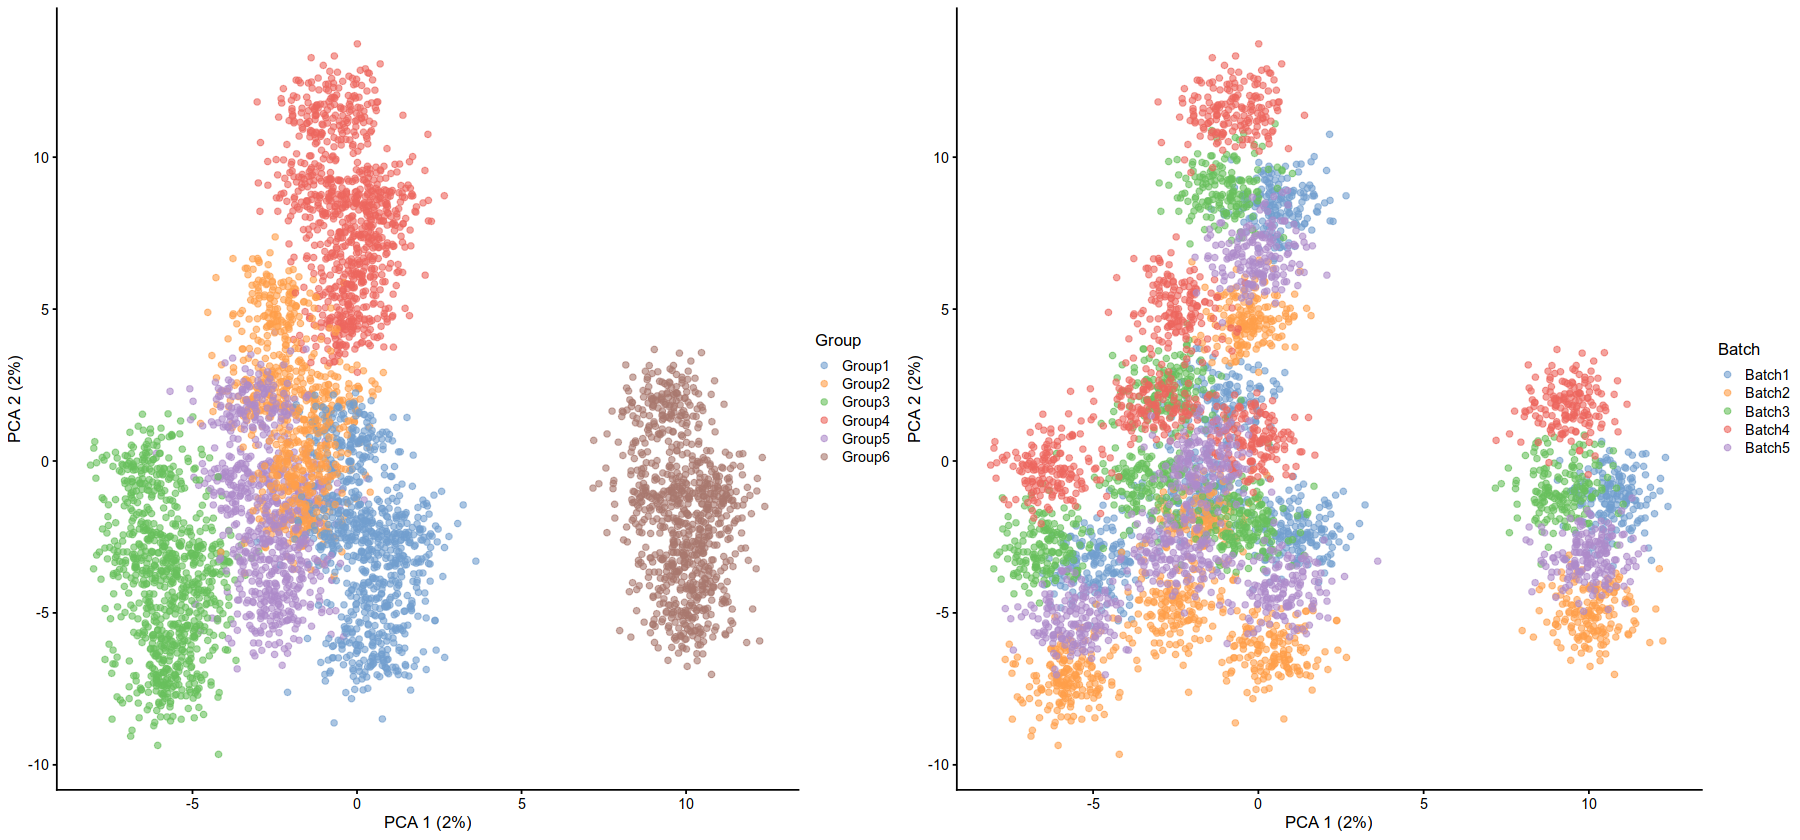

In [6]:
sim.gold.viz<-sim.gold

sim.gold.viz <- scater::logNormCounts(sim.gold.viz)
sim.gold.viz <- scran::fixedPCA(sim.gold.viz, assay.type = 'logcounts', subset.row=NULL) # default 50 PCs

h_ = 7
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

g1a<-plotPCA(sim.gold.viz, colour_by = "Group")
g1b<-plotPCA(sim.gold.viz, colour_by = "Batch")

g1<-ggpubr::ggarrange(g1a, g1b, ncol = 2)
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data.path, 'figures/', 'missing_vals_pca', ext), g1, 
                                             height = h_, width = w_)}
g1

Gold standard CCC tensor with no omitted cell types or LR pairs:

In [7]:
# generate a LR PPI on a subset of the genes
set.seed(seed)
lr.genes<-sort(as.character(sample(rownames(sim.gold), size = n.lrs, replace = FALSE)))
lr.ppi<-generate.lr.ppi(lr.genes)
interacting.lr.genes<-unique(c(lr.ppi$source_genesymbol, lr.ppi$target_genesymbol))

#####

# split by context -- needed for LR omission and scoring
sim.gold.list<-split.by.context(sim.gold) 

# log-normalize
sim.gold.list<-lapply(sim.gold.list, FUN = function(sce) {
    sce <- scater::logNormCounts(sce)
})

# calculate communication scores
scores.gold<-score.communication(sim.gold.list, lr.ppi, n.cores = n.cores)

tensor.gold.elements<-list()
for (score.type in names(scores.gold)){
    tensor.gold.elements[[score.type]]<-get.tensor.elements(scores.gold, score.type)
}

# build and decompose tensor
tensor.gold<-list()
for (score.type in names(scores.gold)){
    tensor.gold[[score.type]]<-liana_tensor_c2c(context_df_dict = scores.gold[[score.type]],
                                       score_col = 'score',
                                       ligand_col = 'ligand', 
                                       receptor_col = 'receptor', 
                                       lr_fill = NaN, 
                                       cell_fill = NaN,
                                       how = 'outer',
                                       seed = 888, 
                                       conda_env = env.name,
                                       build_only = T)

    
}

# get the values that are masked in the gold standard
# these are true zeros which will be used for cheking the fill in the omitted tensors that have masks
zeros.gold<-lapply(tensor.gold, function(tensor.obj) which(tensor.obj$mask == 0, arr.ind = T))
names(zeros.gold)<-names(tensor.gold)
                   
for (score.type in names(tensor.gold)){
    # remove the masked indices so that they are treated as 0 
    # (this is like having set lr_fill and cell_fill above to 0)
    mask<-tensor.gold[[score.type]]$mask
    mask[mask == 0] = 1
    tensor.gold[[score.type]]$mask<-mask
    
    # identify the rank and run the decomposition
    tensor.gold[[score.type]]<-decompose_tensor(tensor = tensor.gold[[score.type]],
                                               score_col = 'score',
                                               ligand_col = 'ligand', 
                                               receptor_col = 'receptor', 
                                               seed = 888, 
                                               upper_rank = 25, 
                                               init = 'svd', 
                                               conda_env = env.name,
                                               factors_only = F, 
                                               inplace = F,
                                               rank = NULL) # estimate the rank by setting to NULL
    print(paste0('The rank using ', score.type, ' is ', tensor.gold[[score.type]]$rank))
}

Loading `ccc_protocols` Conda Environment

Building the tensor...

Loading `ccc_protocols` Conda Environment

Building the tensor...



Loading `ccc_protocols` Conda Environment
TRUE
message
Building the tensor...
TRUE
message
Estimating ranks...
TRUE
message
Decomposing the tensor...
TRUE
message
[1] "The rank using natmi is 4"
Loading `ccc_protocols` Conda Environment
TRUE
message
Building the tensor...
TRUE
message
Estimating ranks...
TRUE
message
Decomposing the tensor...
TRUE
message
[1] "The rank using sca is 6"


Visualize:

New names:
• `Factor 1` -> `Factor.1`
• `Factor 2` -> `Factor.2`
• `Factor 3` -> `Factor.3`
• `Factor 4` -> `Factor.4`
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 5 rows [1, 2, 3, 4, 5].”
New names:
• `Factor 1` -> `Factor.1`
• `Factor 2` -> `Factor.2`
• `Factor 3` -> `Factor.3`
• `Factor 4` -> `Factor.4`
New names:
• `Factor 1` -> `Factor.1`
• `Factor 2` -> `Factor.2`
• `Factor 3` -> `Factor.3`
• `Factor 4` -> `Factor.4`
New names:
• `Factor 1` -> `Factor.1`
• `Factor 2` -> `Factor.2`
• `Factor 3` -> `Factor.3`
• `Factor 4` -> `Factor.4`
• `Factor 5` -> `Factor.5`
• `Factor 6` -> `Factor.6`
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 5 rows [1, 2, 3, 4, 5].”
New names:
• `Factor 1` -> `Factor.1`
• `Factor 2` -> `Factor.2`
• `Factor 3` -> `Factor.3`
• `Factor 4` -> `Factor.4`
• `Factor 5` -> `Factor.5`
• `Factor 6` -> `Factor.6`
New names:
• `Factor 1` -> `Factor.1`
• `Factor 2` -> `Factor.2`
• `Factor 3` -> `Factor.3`
• `Factor 4

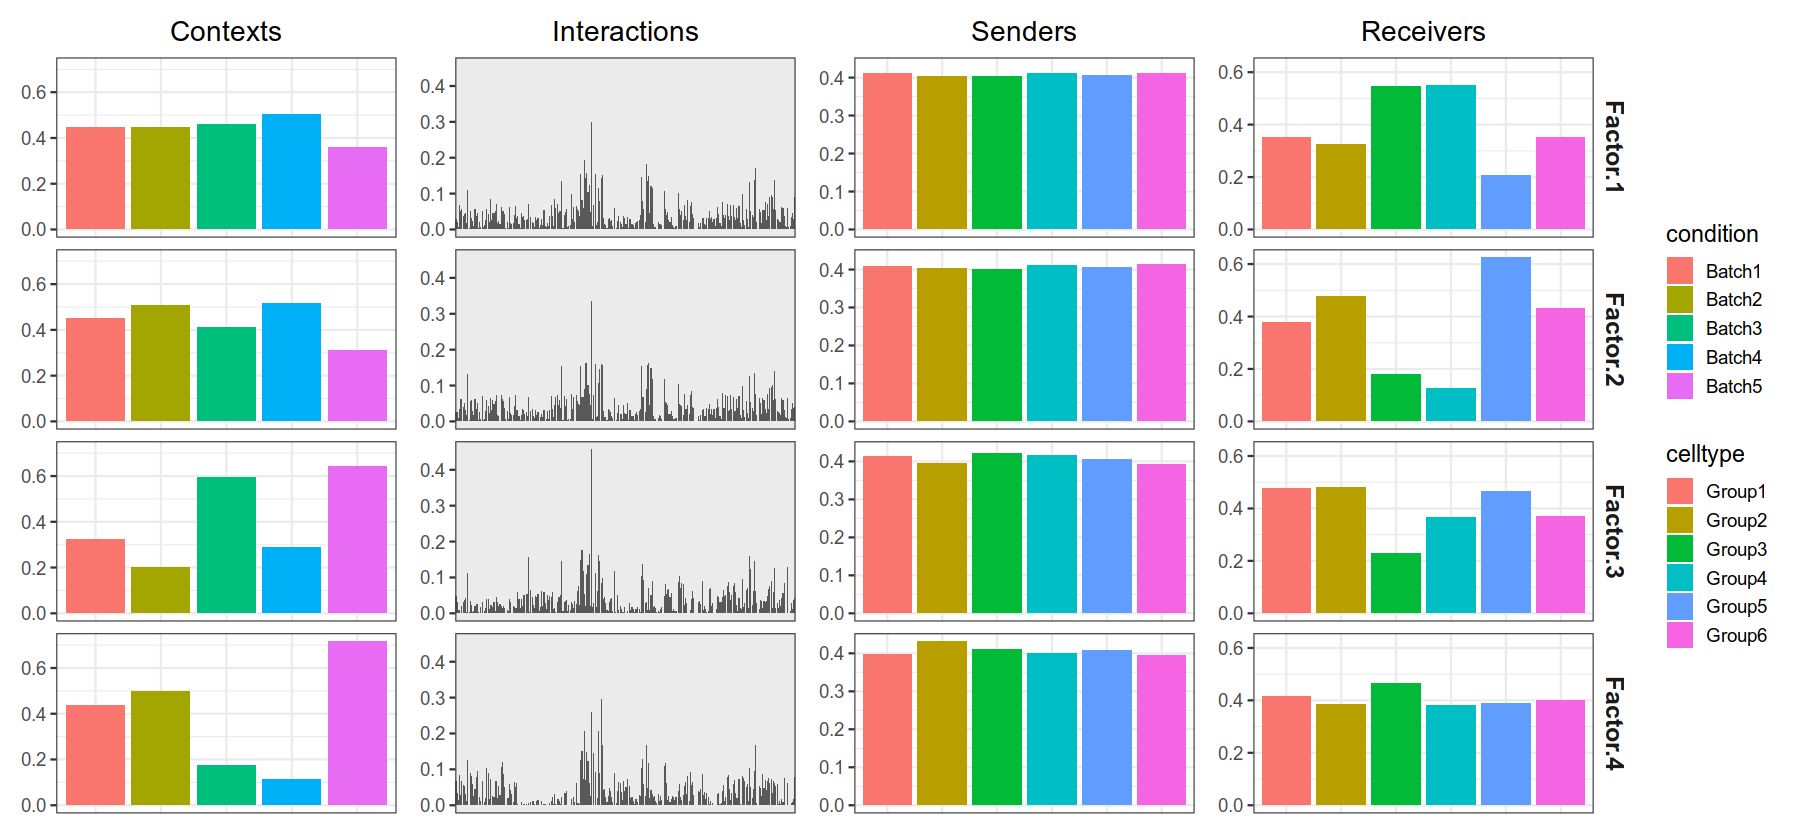

In [8]:
natmi.factors <- format_c2c_factors(tensor.gold$natmi$factors)
sca.factors <- format_c2c_factors(tensor.gold$sca$factors)

# Plot overview
plot_c2c_overview(natmi.factors)

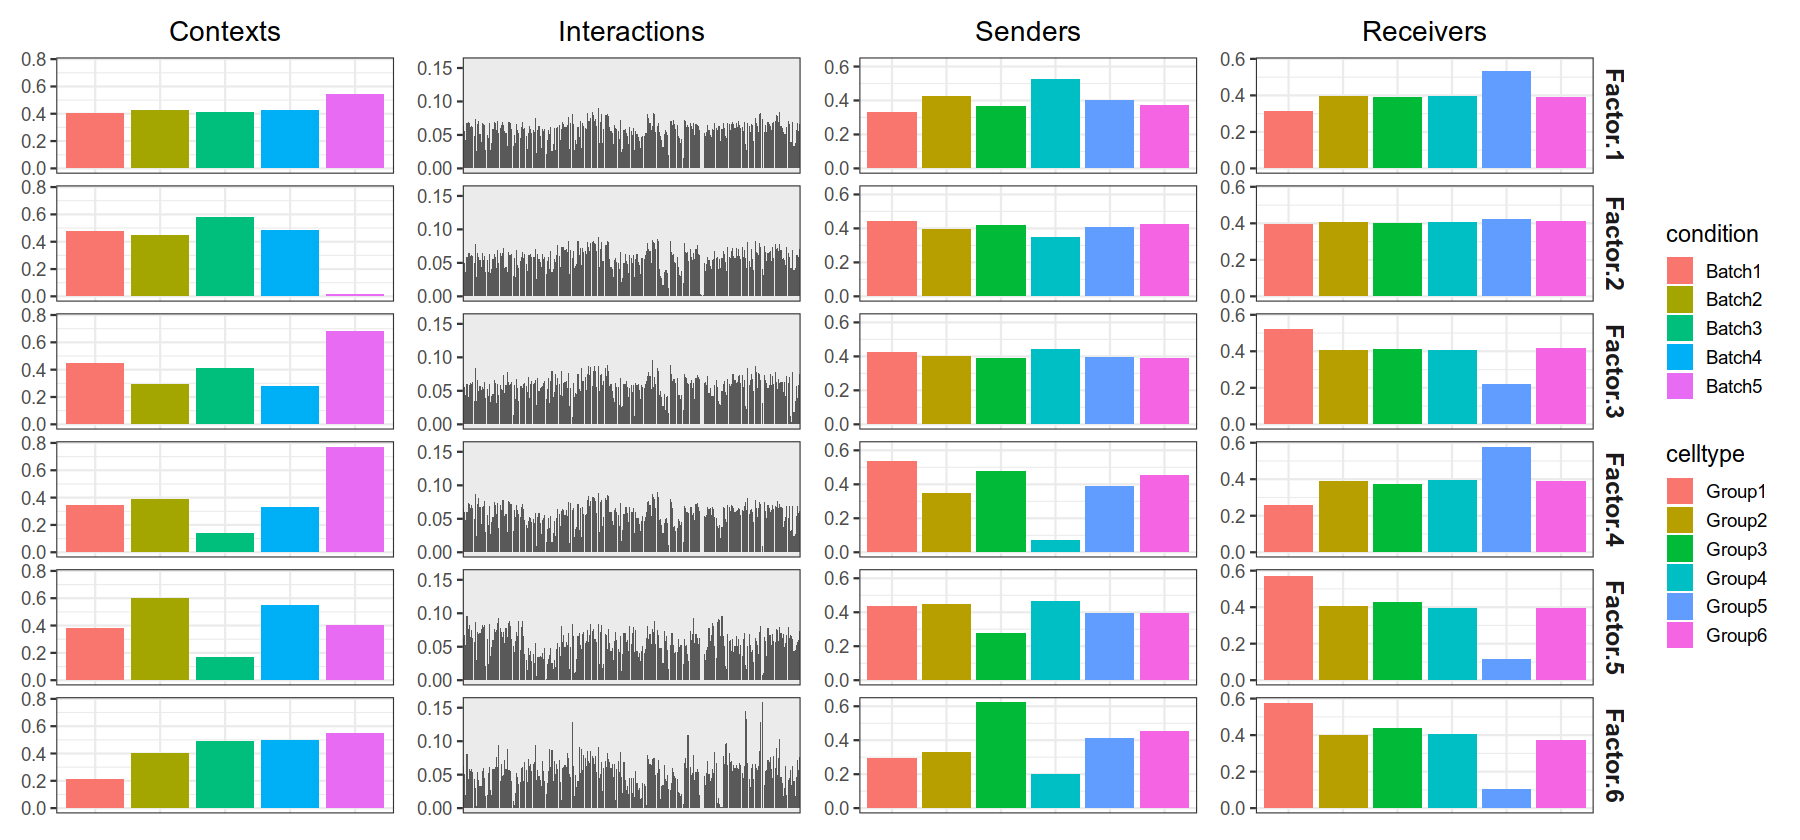

In [9]:
plot_c2c_overview(sca.factors)

## Set up Iterable Parameters

In [22]:
# fraction of .* to omit
frac.contexts = seq(0.2, 0.6, 0.2) # fraction of contexts to omit cell types
frac.cts = seq(1/6, 2/3, 1/6)
frac.lrs = seq(0.1, 0.6, 0.2)

# same or different .* to omit across contexts -- true/same is more difficult problem
consistent.remove.cts = c(TRUE, FALSE) 
consistent.remove.lrs = c(TRUE, FALSE)

The fraction and actual number of cell types to be ommitted is:

In [23]:
frac.contexts
frac.contexts*n.batches

[1] 0.2 0.4 0.6

[1] 1 2 3

The fraction and actual number of cell types to be ommitted is:

In [24]:
frac.cts
frac.cts*n.cell.types

[1] 0.1666667 0.3333333 0.5000000 0.6666667

[1] 1 2 3 4

The fraction and actual number of LRs to be ommitted is:

In [25]:
frac.lrs
frac.lrs*length(interacting.lr.genes)

[1] 0.1 0.3 0.5

[1] 13 39 65

In [26]:
iter.params.list<-list()
counter<-1
for (frac.ct in frac.cts){
    for (frac.lr in frac.lrs){
        for (frac.context in frac.contexts){
            for (cr.ct in consistent.remove.cts){
                for (cr.lr in consistent.remove.lrs){
                    iter.params.list[[counter]]<-list(frac.ct = frac.ct, frac.lr = frac.lr, 
                                                      frac.context = frac.context, cr.ct = cr.ct, cr.lr = cr.lr)
                    counter<-counter + 1
                }
            }
        }
    }
}

## Iterate: NaNs/Masking

In [27]:
print(paste0('The number of iterations is: ', length(iter.params.list)))

[1] "The number of iterations is: 144"


In [29]:
res.df <- data.frame(matrix(ncol = 11, nrow = 0))
res.col.names<-c('iteration', 'celltype.fraction', 'lr.fraction', 'context.fraction', 'celltype.consistent', 'lr.consistent', 
                   'missing.fraction', 'corrindex.masked.natmi', 'corrindex.masked.sca',
                'corrindex.zeros.natmi', 'corrindex.zeros.sca')
colnames(res.df)<-res.col.names

seed.iter<-1
iter<-1

In [32]:
print('Begin iteration: ')
for (iter.params in iter.params.list[1:2]){
    try({

        print(paste0('Iteration no.: ', iter))
        # select contexts, cell types, and LRs to omit-------------------------------------------------------------
        omit.contexts.ct <- random.omit(sim = sim.gold, md.group.label = 'Batch', frac = iter.params$frac.context, seed = seed.iter)
        seed.iter<-seed.iter + 1
        omit.contexts.lr <- random.omit(sim = sim.gold, md.group.label = 'Batch', frac = iter.params$frac.context, seed = seed.iter)
        seed.iter<-seed.iter + 1

        omit.cts <- list()
        if (iter.params$cr.ct){
            ocs <- random.omit(sim = sim.gold, md.group.label = 'Group', frac = iter.params$frac.ct, seed = seed.iter)
            seed.iter<-seed.iter + 1
            for (oc in omit.contexts.ct){
                omit.cts[[oc]] = ocs
            }
        }else{
            for (oc in omit.contexts.ct){
                omit.cts[[oc]] = random.omit(sim = sim.gold, md.group.label = 'Group', frac = iter.params$frac.ct, seed = seed.iter)
                seed.iter<-seed.iter + 1
            }
        }

        omit.lrs <- list()
        if (iter.params$cr.lr){
            set.seed(seed.iter)
            olrs<-sort(as.character(sample(interacting.lr.genes, size = iter.params$frac.lr*length(interacting.lr.genes), replace = FALSE)))
            seed.iter<-seed.iter + 1
            for (oc in omit.contexts.lr){
                omit.lrs[[oc]] = olrs
            }
        }else{
            for (oc in omit.contexts.lr){
                set.seed(seed.iter)
                olrs<-as.character(sample(interacting.lr.genes, size = iter.params$frac.lr*length(interacting.lr.genes), replace = FALSE))
                omit.lrs[[oc]] = olrs
                seed.iter<-seed.iter + 1
            }
        }
        # ----------------------------------------------------------------------------------------------------------
        set.seed(seed) # reset to main

        # apply the omissions
        sim.omit.list<-sim.gold.list

        for (context in names(omit.cts)){
            sce.omit <- sim.omit.list[[context]]
            cell.types.omit = omit.cts[[context]]
            barcodes.keep = rownames(colData(sce.omit)[!(colData(sce.omit)$Group %in% cell.types.omit),])
            sim.omit.list[[context]] <- sce.omit[, barcodes.keep]
        }


        for (context in names(omit.lrs)){
            sce.omit<-sim.omit.list[[context]]
            sim.omit.list[[context]]<-sce.omit[!(rownames(sce.omit) %in% omit.lrs[[context]]), ]
        }

        # get the communication scores------------------------------------------------------------------------------
        # only re-calculate scores on altered contexts to save computation time

        changed.contexts<-sort(unique(c(omit.contexts.ct, omit.contexts.lr)))
        scores.omit<-score.communication(sim.omit.list, lr.ppi, changed.contexts, n.cores = n.cores)

        scores.omit[['natmi']]<-c(scores.omit$natmi, 
                                          scores.gold$natmi[!(names(scores.gold$natmi) %in% changed.contexts)])
        scores.omit[['sca']]<-c(scores.omit$sca, 
                                          scores.gold$sca[!(names(scores.gold$sca) %in% changed.contexts)])
        scores.omit<-lapply(scores.omit, function(x) x[sort(names(x))])
        
                            
        # this will restore LR pairs that were completely removed during omitting process
        # happens bc they are not present in all contexts, so if removed in some contexts, may completely dissapear
        # making tensor dimensions different and corrindex calulation impossible
        # improve: should directly insert into tensor; right now using hacky way where adding the missing LRs
        # to any of the sample communication matrices will automatically add it to the constructed tensor
        tensor.omit.elements<-list()
        for (score.type in names(scores.omit)){
            tensor.omit.elements[[score.type]]<-get.tensor.elements(scores.omit, score.type)
        }

        for (score.type in names(scores.omit)){
            for (element.type in names(tensor.omit.elements[[score.type]])){
                elements.gold<-tensor.gold.elements[[score.type]][[element.type]]
                elements.omit<-tensor.omit.elements[[score.type]][[element.type]]
                if (length(elements.omit) < length(elements.gold)){
                    if (element.type != 'LRs'){stop('Need to account for non-LR missing elements')}
                    elements.missing<-setdiff(elements.gold, elements.omit)
                    # inserting missing LRs with a NaN score should make the tensor dimensions consistent
                    # this will add a mask for these missing lrs
                    for(em in elements.missing){
                        context.score<-scores.omit[[score.type]][[1]]
                        to.add<-context.score[1, ]
                        to.add[['score']]<-NaN
                        lr.missing<-stringr::str_split(em, pattern='&')[[1]]
                        to.add[['ligand']]<-lr.missing[[1]]
                        to.add[['receptor']]<-lr.missing[[2]]
                        scores.omit[[score.type]][[1]]<-rbind(context.score, to.add)

                    }
                }
            }
        }                    
                            
        # run tensor-c2c and get the corrindex for each score type
        frac.missing = list()
        corr.index = list(masked = list(), zeros = list())

        for (score.type in names(scores.omit)){
            suppressMessages({
                suppressWarnings({
                    # build
                    tensor<-liana_tensor_c2c(context_df_dict = scores.omit[[score.type]],
                                                       score_col = 'score',
                                                       ligand_col = 'ligand', 
                                                       receptor_col = 'receptor', 
                                                       how = 'outer',
                                                       seed = 888, 
                                                       init = 'svd', 
                                                       conda_env = env.name,
                                                       build_only = T,
                                                       rank = tensor.gold[[score.type]]$rank)
                    # mask
                    # masking will also add masks to values that were true 0 in the gold-standard but that 
                    # would have been masked using the lr_fill/cell_fill because of the structure of the dataset (i.e., the zero.gold)
                    # here, we determine whether this case should be actually masked (because we deliberately omitted something)
                    # or whether they should not be masked (because we did not deliberately omit it, but it received a mask due to the dataset structure)
                    masked.omit<-which(tensor$mask == 0, arr.ind = T)
                    masked.overlap.idxs<-match(do.call(paste, data.frame(zeros.gold[[score.type]])), 
                                              do.call(paste, data.frame(masked.omit)))
                    if (length(masked.overlap.idxs) != dim(zeros.gold[[score.type]])[[1]]){
                        stop('The gold standard masked values should be a subset of the omitted tensor masked values')
                    }

                    masked.overlap.idx<-masked.overlap.idxs[[1]]
                    zeros.omit.idx<-c()
                    for (masked.overlap.idx in masked.overlap.idxs){
                        masked.overlap<-lapply(1:4, function(i) tensor$order_names[[i]][masked.omit[masked.overlap.idx,][[i]]])
                        masked.overlap[[2]]<-stringr::str_split(masked.overlap[[2]], pattern="\\^")[[1]]
                        masked.overlap[[3]]<-unique(c(masked.overlap[[3]], masked.overlap[[4]]))

                        masked.contexts<-unique(c(omit.contexts.ct, omit.contexts.lr))

                        masked = F
                        # if (masked.overlap[[1]] %in% omit.contexts.ct){
                        if (length(intersect(masked.overlap[[3]], omit.cts[[masked.overlap[[1]]]])) > 0){
                            masked = T
                        }

                        if (length(intersect(masked.overlap[[2]], omit.lrs[[masked.overlap[[1]]]]) > 0)){
                            masked = T
                        }

                        # still a true zero, only had NaN filled in because tensor building unaware of gold-standard
                        if (!masked){
                            zeros.omit.idx<-c(zeros.omit.idx, masked.overlap.idx)
                        }

                    }
                    # do not mask values that are still true 0s
                    zeros.omit<-masked.omit[zeros.omit.idx, ]
                    tensor$mask[zeros.omit]<-1

                    frac.missing[[score.type]]<-length(which(tensor$mask == 0))/length(tensor$mask)

                    # now run the decomposition
                    tensor<-decompose_tensor(tensor = tensor,
                                           score_col = 'score',
                                           ligand_col = 'ligand', 
                                           receptor_col = 'receptor', 
                                           seed = 888, 
                                           init = 'svd', 
                                           conda_env = env.name,
                                           factors_only = F, 
                                           inplace = F,
                                           rank = tensor.gold[[score.type]]$rank)


                    # calculate corrindex
                    corr.index$masked[[score.type]]<- (1 - (c2c$tensor$metrics$correlation_index(tensor.gold[[score.type]]$factors, 
                                                                                                   tensor$factors)))

                    # re-do setting missing values as true 0
                    tensor$mask[tensor$mask == 0] = 1 
                    tensor<-decompose_tensor(tensor = tensor,
                                           score_col = 'score',
                                           ligand_col = 'ligand', 
                                           receptor_col = 'receptor', 
                                           seed = 888, 
                                           init = 'svd', 
                                           conda_env = env.name,
                                           factors_only = F, 
                                           inplace = F,
                                           rank = tensor.gold[[score.type]]$rank)
                    corr.index$zeros[[score.type]]<- (1 - (c2c$tensor$metrics$correlation_index(tensor.gold[[score.type]]$factors, 
                                                                                                       tensor$factors)))
                    })
                })
        }
        if (length(unique(frac.missing)) != 1){stop('Unexpected difference between score type missing indices')}  
        frac.missing<-unique(frac.missing)[[1]]

        res<-c(iter, unname(unlist(iter.params)), frac.missing, corr.index$masked$natmi, corr.index$masked$sca,
              corr.index$zeros$natmi, corr.index$zeros$sca)
        names(res)<-res.col.names
        res.df<-rbind(res.df, t(as.data.frame(res)))

        write.csv(res.df, paste0(data.path, 'interim/', 'missing_vals_benchmark.csv'))
    })
    iter<-iter + 1
}

# Analyse

## Visualize

In [3]:
res.df<-read.csv(paste0(data.path, 'interim/', 'missing_vals_benchmark.csv'))
res.df<-res.df[colnames(res.df) != 'X']

In [4]:
head(res.df)

,iteration,celltype.fraction,lr.fraction,context.fraction,celltype.consistent,lr.consistent,missing.fraction,corrindex.masked.natmi,corrindex.masked.sca,corrindex.zeros.natmi,corrindex.zeros.sca
,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.1666667,0.1,0.2,1,1,0.12684538,0.9922874,0.9944951,0.9033496,0.9194980
2,2,0.1666667,0.1,0.2,1,0,0.10516706,0.9949213,0.9961801,0.9001210,0.9222146
3,3,0.1666667,0.1,0.2,0,1,0.09170552,0.9976830,0.9943461,0.9466598,0.9489745
4,4,0.1666667,0.1,0.2,0,0,0.08418803,0.9934933,0.9933053,0.9248664,0.9286424
5,5,0.1666667,0.1,0.4,1,1,0.16107226,0.9835606,0.9941800,0.9109275,0.9188454
6,6,0.1666667,0.1,0.4,1,0,0.18818959,0.9785396,0.9900414,0.8931118,0.8927609


In [12]:
viz.df<-res.df[,1:(dim(res.df)[[2]]-4)]

viz.df.masked<-cbind(viz.df, res.df[c('corrindex.masked.natmi', 'corrindex.masked.natmi')])
colnames(viz.df.masked)<-c(colnames(viz.df.masked)[1:(dim(viz.df.masked)[[2]]-2)], 'natmi', 'sca')
viz.df.masked<-melt(viz.df.masked, id=colnames(viz.df.masked)[!colnames(viz.df.masked) %in% c('natmi', 'sca')], 
    value.name = 'corrindex', variable.name = 'score.type')
viz.df.masked[['masked']]<-TRUE

viz.df.zeros<-cbind(viz.df, res.df[c('corrindex.zeros.natmi', 'corrindex.zeros.natmi')])
colnames(viz.df.zeros)<-c(colnames(viz.df.zeros)[1:(dim(viz.df.zeros)[[2]]-2)], 'natmi', 'sca')
viz.df.zeros<-melt(viz.df.zeros, id=colnames(viz.df.zeros)[!colnames(viz.df.zeros) %in% c('natmi', 'sca')], 
    value.name = 'corrindex', variable.name = 'score.type')
viz.df.zeros[['masked']]<-FALSE

viz.df<-rbind(viz.df.masked, viz.df.zeros)

viz.df[['celltype.consistent']]<-as.factor(viz.df$celltype.consistent)
viz.df[['lr.consistent']]<-as.factor(viz.df$celltype.consistent)

Does the fraction of missing indices effect the CorrIndex?

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



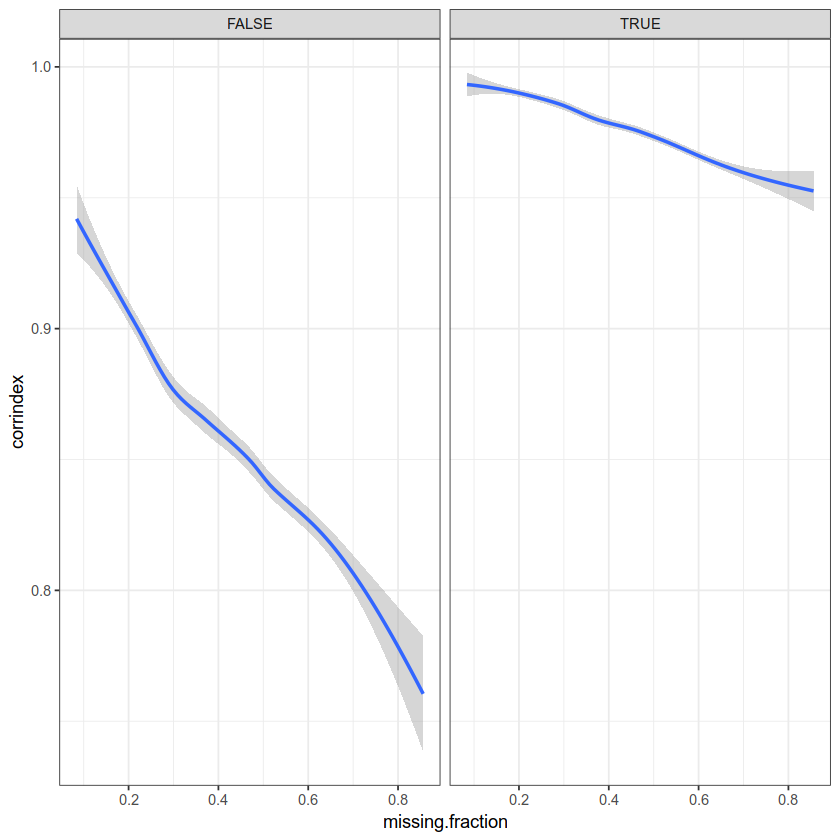

In [6]:
g1<-ggplot(viz.df, aes(x=missing.fraction, y=corrindex)) +
  geom_smooth() + facet_wrap(~masked) + theme_bw()
g1

Conclusion: While the fraction of missing indices clearly has an effect on CorrIndex (likely statistically significant), the effect size is pretty negligible 

Do either the score type or whether the same element is removed change the effect of the missing fraction on the CorrIndex?

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



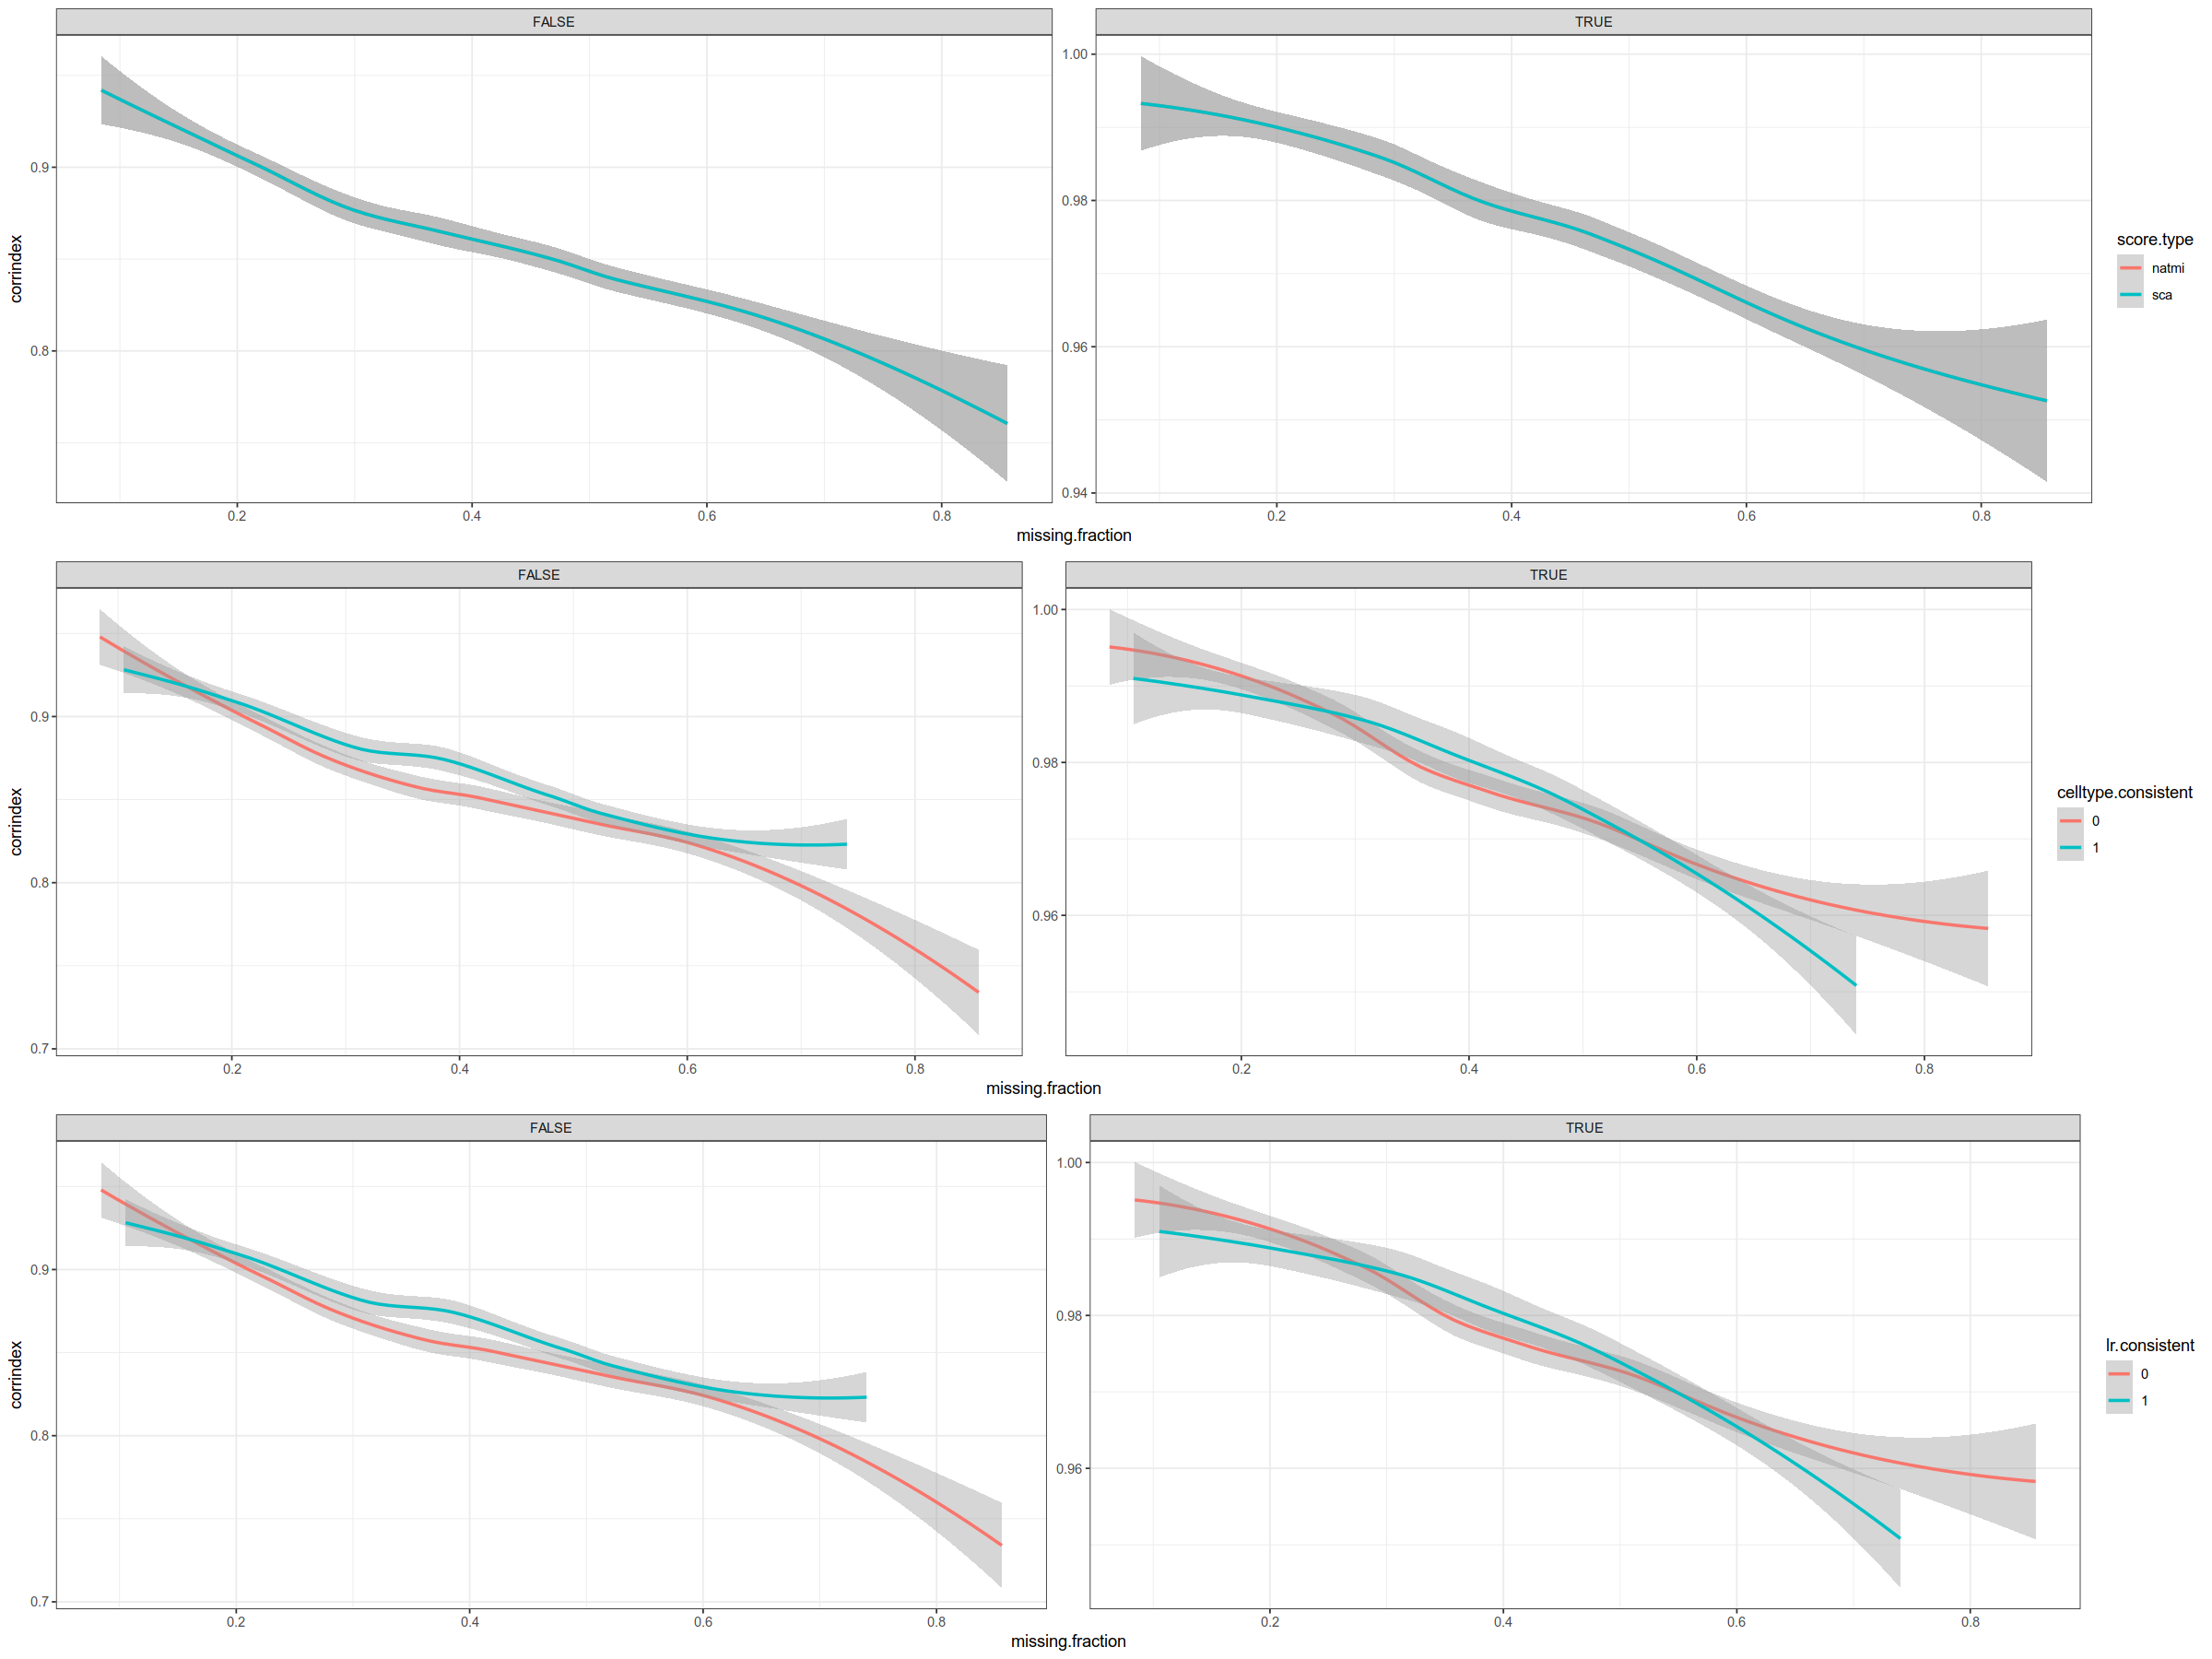

In [15]:
h_ = 15
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

g2a<-ggplot(viz.df, aes(x=missing.fraction, y=corrindex, color = score.type)) +
  geom_smooth() + facet_wrap(~masked, scales = 'free') + theme_bw()
g2b<-ggplot(viz.df, aes(x=missing.fraction, y=corrindex, color = celltype.consistent)) +
  geom_smooth() + facet_wrap(~masked, scales = 'free') + theme_bw()
g2c<-ggplot(viz.df, aes(x=missing.fraction, y=corrindex, color = lr.consistent	)) +
  geom_smooth() + facet_wrap(~masked, scales = 'free') + theme_bw()
g2<-ggpubr::ggarrange(g2a, g2b, g2c, ncol = 1)
g2

* SCA consistnely outperforms NATMI across missing fractions, but there doesnt seem to be a strong effect of scoring method on (i.e., the slopes are the same b)
* Whether the same elements are removed across contexts or different ones doesn’t effect CorrIndex strongly for either the cell type or LR dimensions; at high and low missing fractions, removing the same elements seems to perform slightly worse (need statistical testing with binned violinplots), and vice versa at middle ranges of missing fraction


In [249]:
# head(viz.df)

,iteration,celltype.fraction,lr.fraction,context.fraction,celltype.consistent,lr.consistent,missing.fraction,score.type,corrindex
,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>
1,1,0.1666667,0.1,0.2,1,1,0.12531080,natmi,0.9922528
2,2,0.1666667,0.1,0.2,1,1,0.10437063,natmi,0.9949525
3,3,0.1666667,0.1,0.2,0,0,0.09108392,natmi,0.9976709
4,4,0.1666667,0.1,0.2,0,0,0.08356643,natmi,0.9929904
5,5,0.1666667,0.1,0.4,1,1,0.15957653,natmi,0.9835308
6,6,0.1666667,0.1,0.4,1,1,0.18673271,natmi,0.9789397


Do any of the specific elements going missing have a stronger influence on the CorrIndex (e.g., missing LRs vs missing contexts vs missing cell types)? 

In [306]:
# # # have to add jitter for geome_smooth function, come back to this
# # # https://stackoverflow.com/questions/38864458/loess-warnings-errors-related-to-span-in-r
# # for (col in c('celltype.fraction', 'lr.fraction', 'context.fraction')){
# #     viz.df[[col]] <- jitter(viz.df[[col]], factor = 0.05)
# # }
# for (col in c('celltype.fraction', 'lr.fraction', 'context.fraction')){
#     viz.df[[col]] <- as.factor(viz.df[[col]])
# }



In [327]:
# unique(viz.df$context.fraction)

[1] 0.2 0.4 0.6
Levels: 0.2 0.4 0.6

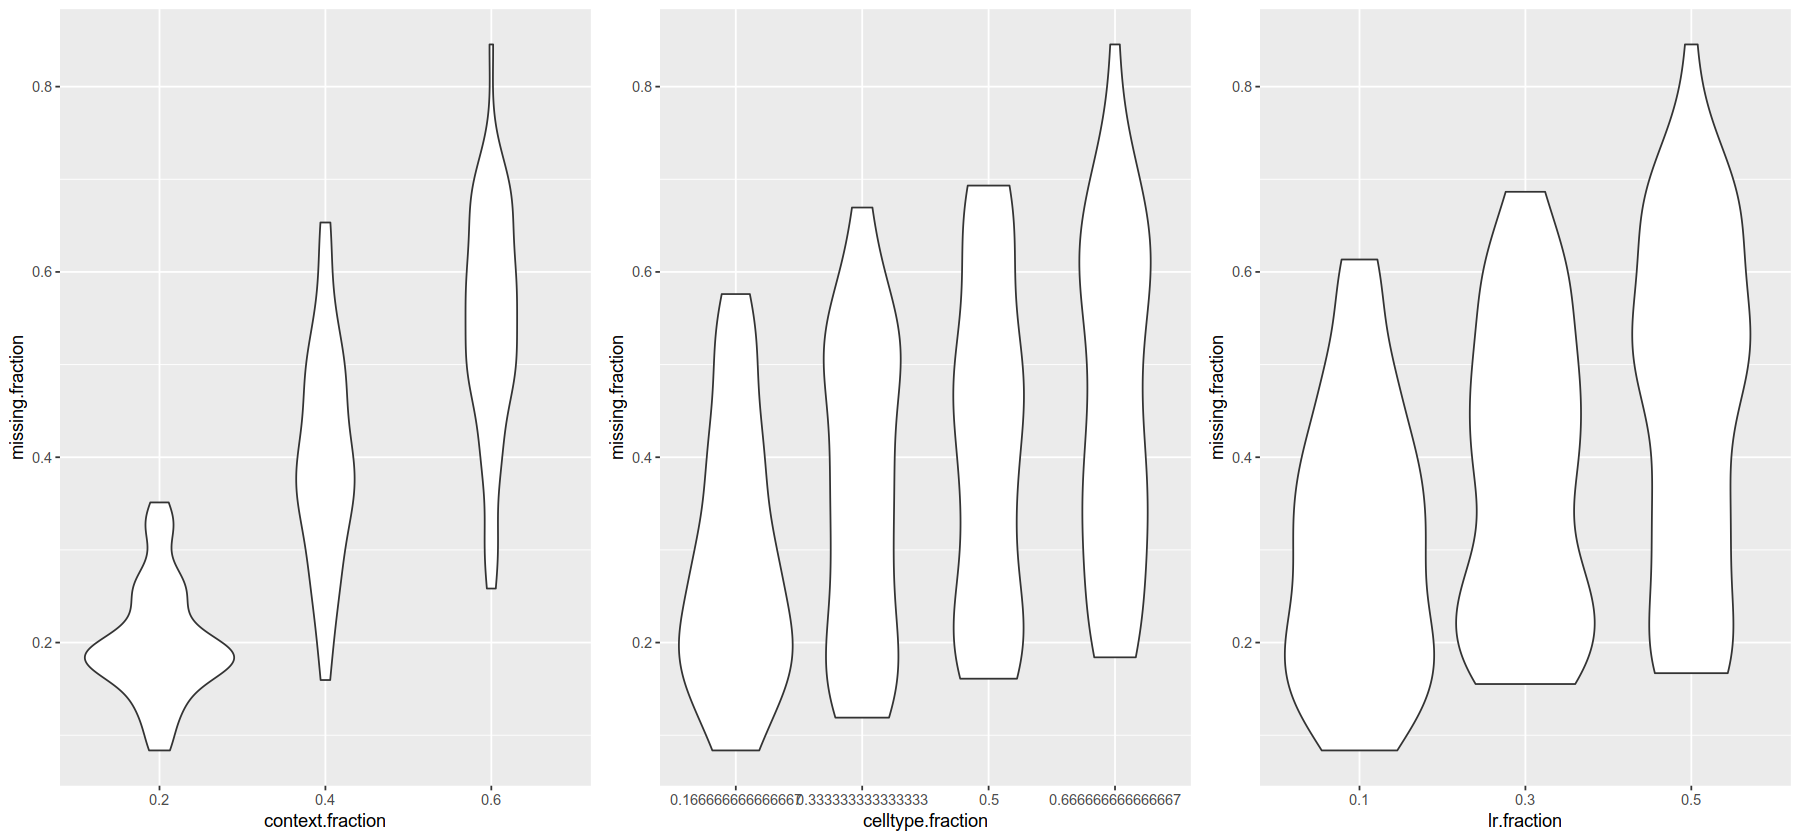

In [331]:
# g3a<-ggplot(viz.df, aes(y=missing.fraction, x=context.fraction)) + geom_violin() 
# g3b<-ggplot(viz.df, aes(y=missing.fraction, x=celltype.fraction)) + geom_violin() 
# g3c<-ggplot(viz.df, aes(y=missing.fraction, x=lr.fraction)) + geom_violin() 

# g3<-ggpubr::ggarrange(g3a, g3b, g3c, ncol = 3)
# g3

First, we see that each has a similar relationship with the total missing fraction. 

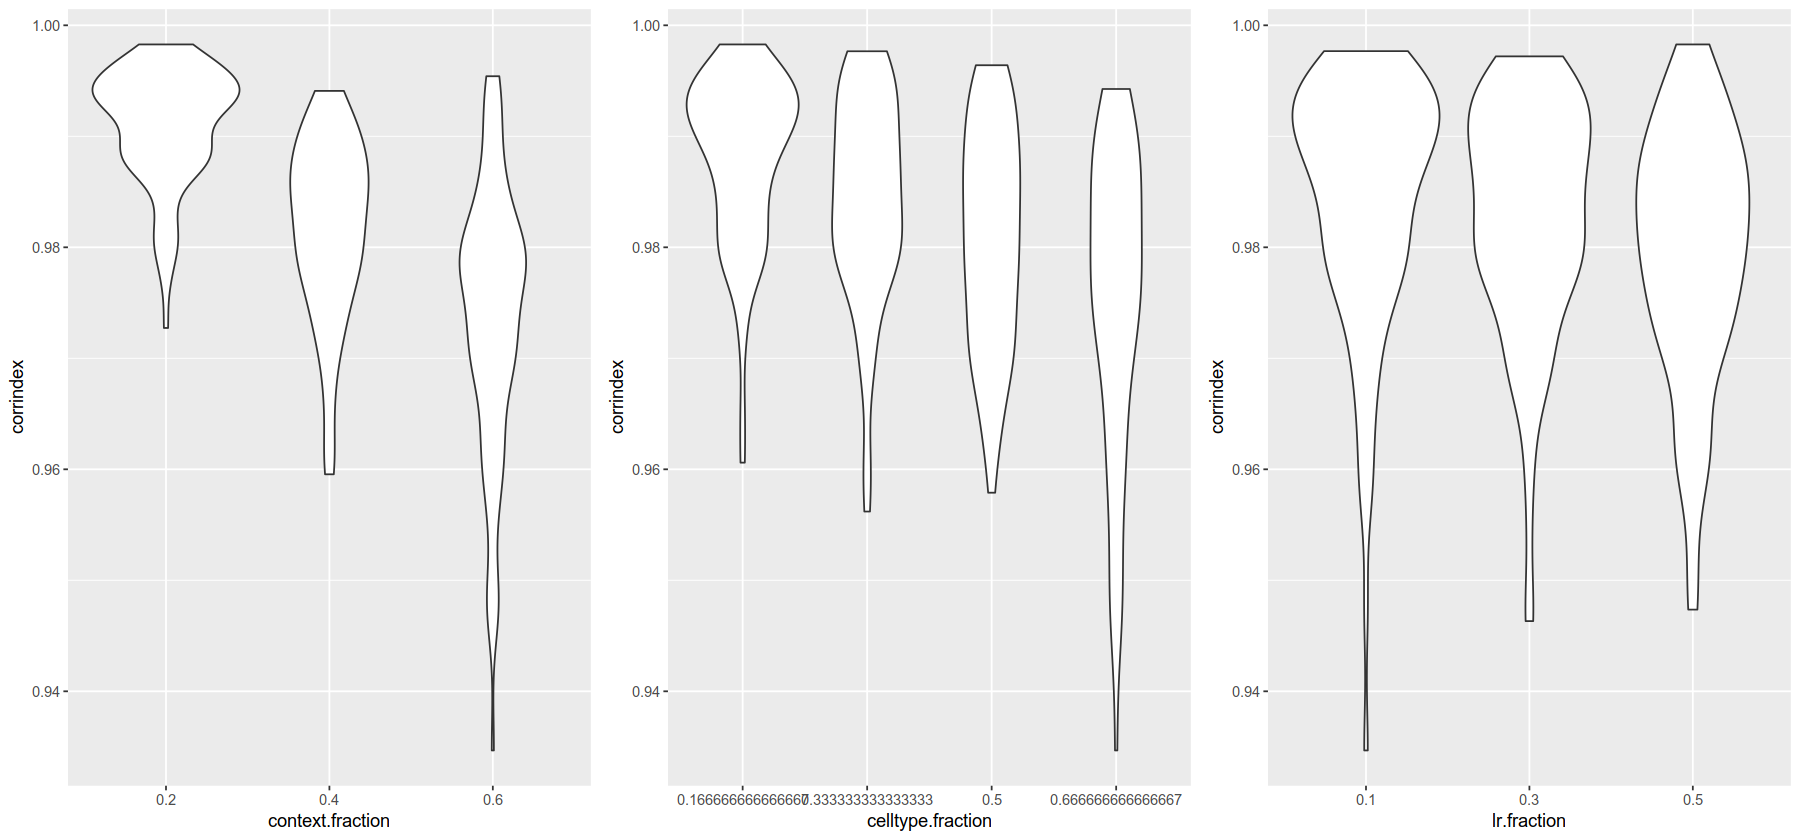

In [333]:
# g4a<-ggplot(viz.df, aes(y=corrindex, x=context.fraction)) + geom_violin() 
# g4b<-ggplot(viz.df, aes(y=corrindex, x=celltype.fraction)) + geom_violin() 
# g4c<-ggplot(viz.df, aes(y=corrindex, x=lr.fraction)) + geom_violin() 

# g4<-ggpubr::ggarrange(g4a, g4b, g4c, ncol = 3)
# g4

Based on the first panel, for better rigor in the future, we may have to first control for how much each of these missing fractions increases the total missing fraction when running this comparison (e.g., overall, a missing ligand receptor fraction will not increase the total missing fraction as much as the other 2 dimensions, so obviously this will have less of an effect on the CorrIndex). Hard to draw any conclusions from just this visual.
